## Project Proposal
#### Students: Gabby Belmarez, Will Blickle, Patrick Corbett, Nick Keeley

### Research question and approach

Latent Dirichlet Allocation is a popular topic model used across many fields, from recommendation algorithms to evolutionary biology. In 2015, the New York Times published a blog post detailing the use of LDA on a new recommendation algorithm for news articles based primarily on topic modeling. Similar to the New York Times, we would like to create a Latent Dirichlet Allocation model to categorize news articles by topic.

One difficulty in implementing a Latent Dirichlet Allocation is in finding the posterior probability. Two common approaches of approximate inference have emerged as a result: variational bayesian inference like Jansen's inequality using Kullback–Leibler divergence (used in SciKit-Learn) or sampling approximations like Markov Chain Monte-Carlo or collapsed Gibb's sampling (Genesism). One newer method to solve this approximation problem is called prodLDA. It uses a Autoencoding variational Bayes (AEVB) which uses a neural net to approximate the posterior in Bayes inference. 

We plan to create an LDA model for News Classification and compare the uncertainty (perplexity) of the three methods of estimating posterior probabilities. Our goal is not simply to compare performance of the different methods, but to understand how they are used to approximate posterior distributions and the trade-offs of each for our news classification model.

### Data 
We will use Kaggle's News Category Dataset. This dataset consists of data from 200k headlines from the Huffington Post between 2012 and 2018. It consists of 41 different categories. Each element in the dataset has the following fields: category, headline, authors, link, short_description, and date. Below is an example element.

In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
 
api = KaggleApi()
api.authenticate()
 
api.dataset_download_files('rmisra/news-category-dataset/News_Category_Dataset_v2.json')

zf = ZipFile('news-category-dataset.zip')
zf.extractall()
zf.close()

In [4]:
import math
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
import json
import pymc3 as pm, theano.tensor as t
import os
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch
assert pyro.__version__.startswith('1.7.0')
import random
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.special import gammaln, psi
from numpy.random import multinomial
from numpy.random import randint



WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
import json
import pandas as pd

nyt_news = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [194]:
#Can run this cell to read in data if Kaggle package causes issues
# nyt_news = pd.read_csv('News_Category_Dataset_v2.csv')

In [6]:
nyt_news.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


# Autoencoding Variational Bayes in Latent Dirichlet Allocation

## Autoencoder Portion


"Both mean-field and collapsed Gibbs have the drawback that applying them to new topic models, even if there is only a small change to the modeling assumptions, requires re-deriving the inference methods, which can be mathematically arduous and time consuming, and limits the ability of practitioners to freely explore the space of different modeling assumptions. Autoencoding variational Bayes (AEVB) is a particularly natural choice for topic models, because it trains an encoder network, a neural network that directly maps a document to an approximate posterior distribution, without the need to run further variational updates. However, despite some notable successes for latent Gaussian models, black box inference methods are significantly more challenging to apply to topic models. Two main challenges are: first, the Dirichlet prior is not a location scale family, which hinders reparameterization, and second, the well known problem of component collapse, in which the encoder network becomes stuck in a bad local optimum in which all topics are identical."

"In the paper Autoencoding Variational Inference For Topic Models from 2017, Akash Srivastava and Charles Sutton addressed both these challenges. They presented the first effective AEVB inference method for topic models, and illustrated it by introducing a new topic model called ProdLDA, which produces better topics than standard LDA, is fast and computationally efficent, and does not require complex mathematical derivations to accomodate changes to the model."


In [11]:
d = nyt_news['short_description']

In [13]:
#### Directly form the paper
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange


d = nyt_news['short_description']
# d = entertainment
max_df = 0.5
min_df = 100

vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(d).toarray())
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))


Dictionary size: 3443
Corpus size: torch.Size([200853, 3443])


In [14]:
#### Directly from paper

## Tokenize words in documents

# replaced news with nyt data from paper's code
d = nyt_news['short_description']
max_df = 0.5
min_df = 100

vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(d).toarray())
vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))

Dictionary size: 3443
Corpus size: torch.Size([200853, 3443])


Feed Forward Neural Network example (architecture doesn't match our network), as described in https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c

![](FNN_Example.jpg)

In [16]:
#### Directly from paper, with personal ## comments to explain what's happening

## This is code for a "Feed Forward" Neural Network, which is a "vanilla" neural net in which node connections
## aren't cyclical, so information only travels forward.

class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        ## Means inherited from parent class, nn.Module
        super().__init__() 
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        ## nn.Linear() creates linear combination for "first fully connected" layer(input nodes, hidden nodes)
        self.fc1 = nn.Linear(vocab_size, hidden) 
        ## Second "fully connected" layer (hidden -> hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        ## Approximating dirichlet distribution with logistic-normal distribution (softmax-normal), parameters: mu, var
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        
        ## Batch Normalization is input layer standardization technique that addresses internal covariate shift of complex neural nets 
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        
    ## Method that drives the encoding/feed forward process
    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale

In [17]:
#### Directly from paper, with personal ## comments to explain what's happening


## Class for decoding our target latent variable distributions (h?)

class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        ## This translates to p(w_n | beta, theta), which is the probability dist. of an nth word given a dist. 
        ## of document topics and the per-topic word distribution beta.
        ## F.softmax() is a function that normalizes a desired dimension through rescaling, generating values between
        ## 0 and 1.
        return F.softmax(self.bn(self.beta(inputs)), dim=1)

In [18]:
#### Directly from paper, with personal ## comments to explain what's happening

## Class for actually executing the full encoding-decoding process.

class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)
        self.logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
        self.logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
        self.logtheta = None
        self.theta = None

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            ## Creating N x Theta matrix for topic "locations." For log normal dist, location = mean.
            ## N = # of documents and Theta = # of topics input. 
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            ## Creating N x Theta matrix for topic "scales." For log normal dist, scale = standard deviation.
            ## N = # of documents and Theta = # of topics input. 
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            ## to_event(1) classifies the logtheta_scale batch dimension as "dependent" rather than independent.
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            self.theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(self.theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                ## Multinomial distribution using maximum word count as total word count and theta estimates??
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            self.logtheta_loc, self.logtheta_scale = self.encoder(docs)
            self.logtheta = pyro.sample(
                "logtheta", dist.Normal(self.logtheta_loc, self.logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T
    

In [19]:
#### Directly from paper, with personal ## comments to explain what's happening

## Setting inputs for model training. I'm going to do it on 10 epochs instead of 50 to reduce computational lift.

# setting global variables
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 10
docs = docs.float().to(device)
batch_size = 32
learning_rate = 1e-3
num_epochs = 10 ## Changed from 50 to 10



In [20]:
#### Directly from paper, with personal ## comments to explain what's happening

## Train the model using specified inputs.

# training
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=10,
    dropout=0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size)) 
bar = trange(num_epochs)


for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

100%|██████████| 10/10 [10:27<00:00, 62.80s/it, epoch_loss=2.93e+05]


### Examine Topics Produced

In [21]:
beta = prodLDA.beta()
topics_autoencoder = pd.DataFrame()
for n in range(beta.shape[0]):
    sorted_, indices = torch.sort(beta[n], descending=True)
    df = pd.DataFrame(indices[:10].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].rename({'word':('Topic ' + str(n+1))})
    topics_autoencoder = topics_autoencoder.append(words.transpose()).reset_index().drop('index', axis = 1)

n_words = 10
cols = list()
for i in range(n_words):
    cols.append("Word "+(str(i)))
topics_autoencoder.columns = cols
topics_autoencoder.index.name = 'Topic'
topics_autoencoder

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic,,,,,,,,,,
0,drug,worst,sugar,snow,era,second,images,store,collection,huffington
1,life,people,don,just,make,like,need,time,love,really
2,want,sure,check,photos,facebook,twitter,pinterest,style,stylelist,say
3,mood,getaway,wine,shoot,cook,dressing,fish,written,curious,star
4,don,people,time,just,like,know,need,life,ve,make
5,need,life,make,way,know,don,world,good,ve,healthy
6,life,love,don,time,people,just,ve,way,things,know
7,national,study,according,fashion,published,percent,friday,american,research,white
8,just,time,way,make,don,life,people,like,know,really


### Find Topic Probabilities by Document

In [22]:
##Now that we have trained the model, we run the encoder on all docs to get the posterior estimates of the trained latent variables
logtheta_loc, logtheta_scale = prodLDA.encoder(docs)
logtheta = pyro.sample(
    "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

#use the same softmax function as in the autoencoder to normalize the posterior estimates
theta = F.softmax(logtheta, -1).detach().numpy()
theta_autoencoder = pd.DataFrame(theta)

cols = list()
for i in range(theta_autoencoder.shape[1]):
    cols.append("Topic "+(str(i)))

theta_autoencoder.columns = cols

In [54]:


theta_autoencoder[:10]

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
0,0.046713,0.200640,0.205365,0.037742,0.024970,0.191294,0.124462,0.021821,0.053959,0.093036
1,0.517624,0.119334,0.075632,0.107291,0.009648,0.016911,0.055860,0.028250,0.031365,0.038085
2,0.030352,0.031601,0.112069,0.281956,0.286381,0.034283,0.110730,0.056883,0.011533,0.044212
3,0.049927,0.027088,0.078186,0.024201,0.437420,0.009020,0.039895,0.227633,0.054457,0.052172
4,0.088276,0.064005,0.041158,0.017600,0.093019,0.252250,0.092983,0.148301,0.120307,0.082102
5,0.074422,0.074883,0.061102,0.016972,0.160164,0.061850,0.179460,0.070348,0.240846,0.059952
6,0.119336,0.036287,0.023109,0.006576,0.290123,0.046069,0.020096,0.279182,0.079994,0.099228
7,0.118775,0.228220,0.038224,0.010809,0.023949,0.164508,0.102333,0.259671,0.021606,0.031907
8,0.063099,0.020893,0.062514,0.048532,0.266145,0.058181,0.039542,0.087254,0.338908,0.014931
9,0.058748,0.306480,0.049384,0.234756,0.069263,0.062869,0.089987,0.025160,0.056224,0.047128


### SKLearn LDA

In [26]:


# Set stop words
stopWords = set(stopwords.words('english'))


#We used the LDA class that we used in class for in class exercises and Homework 5

class LDA_news:
    """Creates a class for Latent Dirichlet Allocation using Kaggle News dataset
    Input:
        reports = list of descriptions of news articles
        N_topics = number of topics for LDA to produce
        N_words = the number of words to show in a topic
        new_article = description of article not in the training set
    Methods:
        Topics = Print the list of topics in the selected narratives
        Predict_Topics = Show the predicted probabilities for topics for a new accident narrative"""
    
    def __init__(self, articles, N_topics=3, N_words = 10):
        # the narrative reports
        self.articles = articles
        # initialize variables
        self.N_topics = N_topics
        self.N_words = N_words
        
        # Get the word counts in the reports
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.termFrequency = self.countVectorizer.fit_transform(self.articles)
        self.Words = self.countVectorizer.get_feature_names()
        
    def Topics(self):
        # Obtain the estimates for the LDA model
        self.lda = LatentDirichletAllocation(n_components=self.N_topics)
        self.lda.fit(self.termFrequency)
        
        # For each of the topics in the model add the top N_words the list of topics
        topics = list()
        for topic in self.lda.components_:
            topics.append([self.Words[i]
                        for i in topic.argsort()[:-self.N_words - 1:-1]])
        
        # Create column names for the output matrix
        cols = list()
        for i in range(self.N_words):
            cols.append("Word "+(str(i)))
            
        # Create a dataframe with the topic no. and the words in each topic 
        # output this dataframe 
        Topics_df = pd.DataFrame(topics, columns = cols)
        Topics_df.index.name = "Topics"
        return Topics_df
    
    def Predict_Topics(self, new_articles):
        self.new_articles = new_articles
        
        # Get the list of new accident report narratives
        # and the number of new narratives
        N_new_articles = len(self.new_articles)
        
        # For each of the new narratives 
        # obtain the estimated probabilities for each of the topics
        # in each of the new narratives as estimated by the LDA results
        # on the training set 
        new_article_topics = list()
        for article in self.new_articles:
            new_article_topics.append(self.lda.transform(self.countVectorizer.transform([article])))
            
        # Recast the list of probabilities for topics as an array 
        # of size no. of new reports X no. of topics
        new_article_topics = np.array(new_article_topics).reshape(N_new_articles, self.N_topics)
        
        # Create column names for the output dataframe
        cols = list()
        for i in range(self.N_topics):
            cols.append("Topic "+(str(i)))
        
        # Create the dataframe whose rows contain topic probabilities for 
        # specificed narratives/reports
        New_Articles_df = pd.DataFrame(new_article_topics, columns = cols )
        New_Articles_df.insert(0, 'Article No.', range(N_new_articles))
        return New_Articles_df
                

In [53]:
random.seed(2020)
lda_news = LDA_news(articles = d, N_topics = 10, N_words = 10)
lda_sklearn_topics = lda_news.Topics()

In [56]:
lda_sklearn_predictions = lda_news.Predict_Topics(d)

## Compare Topics and Distributions across approaches

In [33]:
#autoencoder
topics_autoencoder

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic,,,,,,,,,,
0,drug,worst,sugar,snow,era,second,images,store,collection,huffington
1,life,people,don,just,make,like,need,time,love,really
2,want,sure,check,photos,facebook,twitter,pinterest,style,stylelist,say
3,mood,getaway,wine,shoot,cook,dressing,fish,written,curious,star
4,don,people,time,just,like,know,need,life,ve,make
5,need,life,make,way,know,don,world,good,ve,healthy
6,life,love,don,time,people,just,ve,way,things,know
7,national,study,according,fashion,published,percent,friday,american,research,white
8,just,time,way,make,don,life,people,like,know,really


In [55]:
#SKlearn

lda_sklearn_topics

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topics,,,,,,,,,,
0,people,states,world,year,black,united,women,america,country,national
1,new,check,want,twitter,facebook,huffpost,style,sure,like,york
2,news,video,new,star,study,welcome,host,day,week,morning
3,trump,said,president,donald,state,campaign,says,new,republican,clinton
4,don,children,health,know,kids,people,parents,time,work,new
5,women,love,cancer,marriage,divorce,family,good,men,mother,relationship
6,old,year,just,years,got,did,said,man,white,ago
7,time,day,ve,just,like,year,little,new,make,season
8,make,like,food,great,time,ll,way,culture,good,making


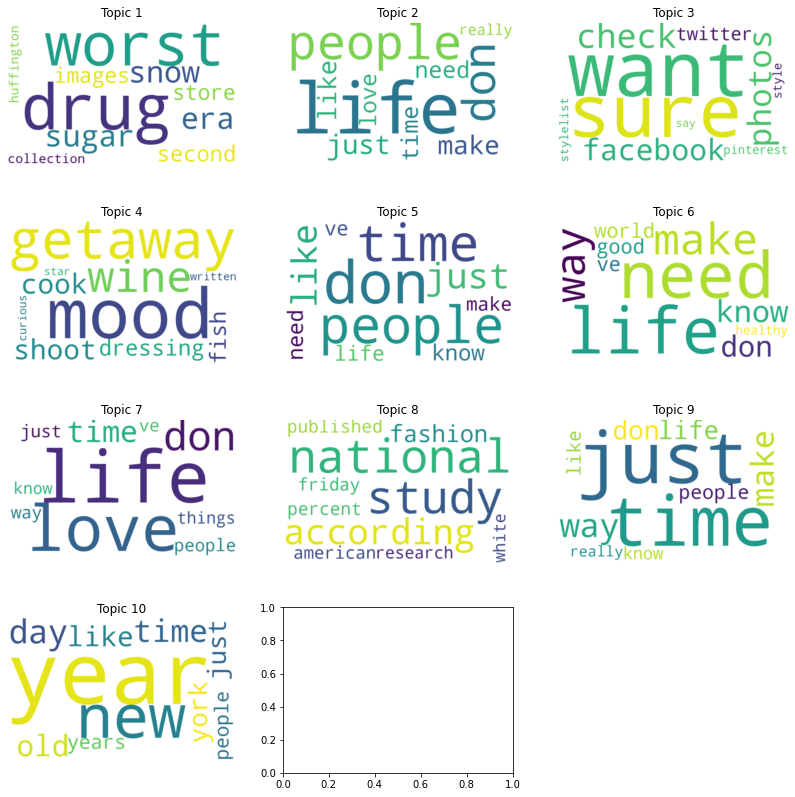

In [35]:
def plot_word_cloud_aevb(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:10].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:10] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

if not smoke_test:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    beta = prodLDA.beta()
    fig, axs = plt.subplots(4, 3, figsize=(14, 14))
    for n in range(beta.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud_aevb(beta[n], axs[i, j], vocab, n)
    axs[-1, -1].axis('off');

    plt.show()


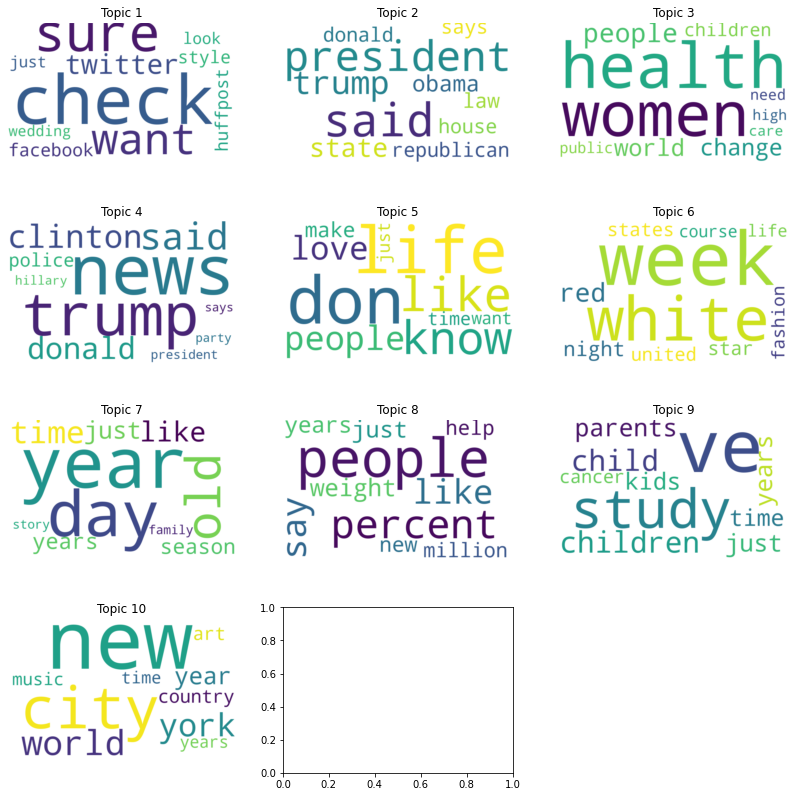

In [37]:
def plot_word_cloud_sklearn(b, ax, n):
#     sorted_, indices = torch.sort(b, descending=True)
#     df = pd.DataFrame(indices[:10].numpy(), columns=['index'])
#     words = pd.merge(df, vocab[['index', 'word']],
#                      how='left', on='index')['word'].values.tolist()
#     sizes = (sorted_[:10] * 1000).int().numpy().tolist()
#     freqs = {words[i]: sizes[i] for i in range(len(words))}
    indices_ = b.argsort()[:-10-1:-1]
    words = [lda_news.Words[i] for i in indices_]
    sorted_ = sorted(b)[:-10-1:-1]
    sizes = (sorted_[:10] * 1000)
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

if not smoke_test:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

#     beta = prodLDA.beta()
    fig, axs = plt.subplots(4, 3, figsize=(14, 14))
    for n in range(lda_news.lda.components_.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud_sklearn(lda_news.lda.components_[n], axs[i, j], n)
    axs[-1, -1].axis('off');

    plt.show()

The topics found by the two methods are quite different, which is interesting on its own. Inspecting them however, Topic 7 in both cases seems to have a lot to do with box office takes, so let's compare those

## Sampling Approach

In [38]:


#gammaln approach is implemented based on approach in Griffiths and Steyvers (https://doi.org/10.1073/pnas.0307752101)
#https://github.com/chriswi93/LDA


class LDABase:
    """
    Base Class to fit LDA using Collapsed Gibbs Sampling derived from 
    Griffiths and Steyvers (2004): Finding scientific topics
    """
    def __init__(self, corpus, K, alpha="asymmetric", beta=0.01):
        """
        Create LDABase instance.
        """
        self.corpus = corpus
        self.K = K # number of topics
        self.W = corpus.get_vocab_len() # number of words in vocabulary
        self.D = len(corpus) # number of documents

        # initialize count parameters
        self.topic_word_count = np.zeros((self.K, self.W))
        self.doc_topic_count = np.zeros((self.D, self.K))
        self.doc_word_topic_assignment = [[0] * len(doc) for doc in corpus]
        self.topic_count = np.zeros(K)
        self.doc_len = corpus.get_doc_len()

        self.num_tokens = np.sum(corpus.get_doc_len()) # num tokens in corpus

        # initialize parameters for estimation phi and theta 
        self.theta = np.zeros((self.D, self.K))
        self.phi = np.zeros((self.K, self.W))

        # initialize priors
        if isinstance(alpha, (np.ndarray, list)):
            # set alpha from parameters
            self.alpha = np.array(alpha)
        elif alpha == "asymmetric":
            # asymmetric prior alpha
            self.alpha = np.array([1.0 / (k + np.sqrt(K)) for k in range(K)])
        else:
            # symmetric prior alpha
            self.alpha = np.array([1.0 / K] * K)
        # symmetric prior beta
        self.beta = beta
        
        self.log_likelihood_trace = []
        self.perplexity_trace = []
        self.theta_trace = []
        self.phi_trace = []
        self.marginal_topic_dist_trace = []
        self.training = True

    def _get_topic_word_idx(self, topn=10):
        """
        Returns matrix with word index and shape (K,topn).
        """
        topic_word_idx_sorted = np.argpartition(self.phi, kth=range(-topn, 0), axis=-1)[:,-topn:]
        topic_word_idx_sorted = np.flip(topic_word_idx_sorted, axis=-1)
        return topic_word_idx_sorted

    def get_topics(self, topn=10):
        """
        Returns topn words from all topics as list of words and list of word probabilities.
        """
        topics_words = []
        topics_probs = []
        for topic_idx, topic in enumerate(self._get_topic_word_idx(topn)):
            words = []
            probs = []
            for word_idx in topic:
                word = self.corpus.idx2word(word_idx)
                prob = self.phi[topic_idx, word_idx]
                words.append(word)
                probs.append(prob)
            topics_probs.append(probs)
            topics_words.append(words)
        return topics_words, topics_probs

    def print_topics(self, topn=10):
        """
        Prints topn words from all topics.
        """
        words, probs = self.get_topics(topn)
        print("p(w|t)\tword\n")
        for topic_idx, (words, probs) in enumerate(zip(words, probs)):
            print("Topic #{}".format(topic_idx + 1))
            for word, prob in zip(words, probs):
                output = "{:.3f}\t{}".format(prob, word)
                print(output)
            print()

    def set_inference_mode(self):
        """
        Disable training mode.
        """
        self.training = False

    def set_training_mode(self):
        """
        Enable training mode.
        """
        self.training = True

    def update(self, doc_idx, word_idx, pos, topic_idx, count):
        """
        Increases or decreases all count parameters by given count value (+1 or -1).
        """
        if self.training is True: # should not change during inference
            self.topic_word_count[topic_idx,word_idx] += count
            self.topic_count[topic_idx] += count
        self.doc_topic_count[doc_idx,topic_idx] += count
        self.doc_word_topic_assignment[doc_idx][pos] = topic_idx

    def get_topic_assignment(self, doc_idx, pos):
        """
        Returns current topic assignment of word in document doc_idx at given position.
        """
        return self.doc_word_topic_assignment[doc_idx][pos]

    def get_phi(self):
        """
        Returns per-topic word distribution phi.
        Griffiths and Steyvers (2004): Finding scientific topics
        """
        phi = np.zeros((self.K, self.W))
        beta_sum = self.beta * self.W
        for z in range(self.K):
            for w in range(self.W):
                phi[z,w] = (self.topic_word_count[z,w] + self.beta) / (self.topic_count[z] + beta_sum)
        return phi
    
    def get_theta(self):
        """
        Returns per-document topic distribution theta.
        Griffiths and Steyvers (2004): Finding scientific topics
        """
        theta = np.zeros((self.D, self.K))
        alpha_sum = np.sum(self.alpha)
        for d in range(self.D):
            for z in range(self.K):
                theta[d,z] = (self.doc_topic_count[d,z] + self.alpha[z]) / (self.doc_len[d] + alpha_sum)
        return theta
    
    def full_conditional_distribution(self, doc_idx, word_idx, topic_idx):
        """
        Returns full conditional distribution for given document index, word index and topic index.
        Griffiths and Steyvers (2004): Finding scientific topics
        """
        n_w_t = self.topic_word_count[:,word_idx] # get word topic count for word index
        n_t = self.topic_count # get topic count
        n_d_t = self.doc_topic_count[doc_idx] # get doc topic count for doc index
        n_d = self.doc_len[doc_idx] # get document word count
        
        word_topic_ratio = (n_w_t + self.beta) / (n_t + self.W * self.beta)
        topic_doc_ratio = (n_d_t + self.alpha) / (n_d + np.sum(self.alpha))
        p_z_cond = word_topic_ratio * topic_doc_ratio
        return p_z_cond / p_z_cond.sum()
    
    def get_log_likelihood(self):
        """
        Returns joint log likelihood p(w, z) = p(w|z)p(z).
        Griffiths and Steyvers (2004): Finding scientific topics
        """
        log_likelihood = 0.0
        for z in range(self.K): # log p(w|z)
            log_likelihood += gammaln(self.W * self.beta)
            log_likelihood -= self.W * gammaln(self.beta)
            log_likelihood += np.sum(gammaln(self.topic_word_count[z] + self.beta))
            log_likelihood -= gammaln(np.sum(self.topic_word_count[z] + self.beta))
        for doc_idx, _ in enumerate(self.corpus): # log p(z)
            log_likelihood += gammaln(np.sum(self.alpha))
            log_likelihood -= np.sum(gammaln(self.alpha))
            log_likelihood += np.sum(gammaln(self.doc_topic_count[doc_idx] + self.alpha))
            log_likelihood -= gammaln(np.sum(self.doc_topic_count[doc_idx] + self.alpha))
        return log_likelihood
    
    def trace_metrics(self):
        """
        Traces metrics to ensure convergency.
        """
        log_likelihood = self.get_log_likelihood()
        perplexity = np.exp(-log_likelihood / self.num_tokens)
        marginal_topic_dist = self.topic_word_count.sum(axis=-1) / self.topic_word_count.sum()
        self.log_likelihood_trace.append(log_likelihood)
        self.perplexity_trace.append(perplexity)
        self.marginal_topic_dist_trace.append(marginal_topic_dist)
    
    def trace_params(self):
        """
        Traces estimates of phi and theta.
        """
        self.phi_trace.append(self.get_phi())
        self.theta_trace.append(self.get_theta())
    
    def plot_topic_prior_alpha(self):
        """
        Plots topic prior alpha.
        """
        pd.DataFrame(self.alpha).plot(legend=False, title="Topic Prior alpha", kind="line")
    
    def plot_metrics(self):
        """
        Plots log likelihood and perplexity trace.
        """
        data = zip(self.log_likelihood_trace, self.perplexity_trace)
        df = pd.DataFrame(data, columns=["Log Likelihood", "Perplexity"])
        df.plot(legend=True, title="Convergence Metrics", figsize=(15,5), subplots=True, layout=(1,2))
    
    def plot_marginal_topic_dist(self, topics=None):
        """
        Plots marginal topic distribution trace.
        """
        pd.DataFrame(self.marginal_topic_dist_trace).plot(title="Marginal Topic Distribution", kind="line", figsize=(15, 10))
    
    def plot_doc_theta_trace(self, doc_idx):
        """
        Plots theta trace for given document.
        """
        pd.DataFrame([theta[doc_idx] for theta in self.theta_trace]).plot(title="Doc #{} Topic Distribution".format(doc_idx), kind="line")

In [39]:


class LDA(LDABase):
    """
    Class to fit LDA using collapsed Gibbs Sampling derived from 
    Griffiths and Steyvers (2004): Finding scientific topics
    """
    def __init__(self, corpus, K, alpha="asymmetric", beta=0.01, samples=100, burnin=200, interval=2, eval_every=5):
        """
        Create LDA instance.
        """
        super().__init__(corpus=corpus, K=K, alpha=alpha, beta=beta)
        self.burnin = burnin
        self.samples = samples
        self.interval = interval
        self.eval_every = eval_every

    def random_init(self):
        """
        Initializes all LDA variables at random.
        """
        for doc_idx, doc in enumerate(self.corpus):
            for pos, word_idx in enumerate(doc):
                new_topic_idx = randint(self.K)
                self.update(doc_idx, word_idx, pos, new_topic_idx, 1)

    def update_params(self, burnin=None, interval=None):
        """
        Updates parameters phi and theta based on parameters burnin and interval.
        Computes mean over all samples in trace.
        """
        if burnin is not None:
            if burnin > self.samples:
                raise AttributeError("burnin > samples is not allowed.")
            self.burnin = burnin
        if interval is not None:
            self.interval = interval
        self._update_phi()
        self._update_theta()

    def _update_phi(self):
        """
        Updates phi based on parameters burnin and interval. 
        """
        if len(self.phi_trace) == 0:
            return
        phi = [phi for idx, phi in enumerate(self.phi_trace[self.burnin:]) if idx % self.interval == 0]
        self.phi = np.array(phi).mean(axis=0)
    
    def _update_theta(self):
        """
        Updates theta based on parameters burnin and interval.
        """
        if len(self.theta_trace) == 0:
            return
        theta = [theta for idx, theta in enumerate(self.theta_trace[self.burnin:]) if idx % self.interval == 0]
        self.theta = np.array(theta).mean(axis=0)
    
    @classmethod
    def create_instance(cls, corpus, K, **kwargs):
        """
        Create new LDA instance.
        """
        return cls(corpus, K=K, **kwargs)
    
    def _optimize_prior_alpha(self):
        """
        Adjust alpha using Minka's fixed-point iteration. 
        See Minka (2000): Estimating a Dirichlet distribution and 
        https://people.cs.umass.edu/~cxl/cs691bm/lec09.html for details.
        """
        num = 0.0
        denom = 0.0
        for doc_idx, _ in enumerate(self.corpus):
            num += psi(self.doc_topic_count[doc_idx] + self.alpha) - psi(self.alpha)
            denom += psi(np.sum(self.doc_topic_count[doc_idx] + self.alpha)) - psi(np.sum(self.alpha))
        self.alpha *= num / denom
    
    def _optimize_prior_beta(self):
        """
        Adjust beta using Minka's fixed-point iteration.
        See Minka (2000): Estimating a Dirichlet distribution and 
        https://people.cs.umass.edu/~cxl/cs691bm/lec09.html for details.
        """
        num = 0.0
        denom = 0.0
        for z in range(self.K):
            num += np.sum(psi(self.topic_word_count[z] + self.beta) - psi(self.beta))
            denom += psi(np.sum(self.topic_word_count[z] + self.beta)) - psi(self.W * self.beta)
        self.beta = (self.beta * num) / (self.W * denom)

    def _sample(self):
        """
        Samples new topic assignmments for words in all documents and updates current state of posterior.
        """
        for doc_idx, doc in enumerate(self.corpus):
            if doc_idx % 100 == 0:
                print("{} / {}\t\t".format(doc_idx, len(self.corpus)), end="\r")
            for pos, word_idx in enumerate(doc):
                # get topic assignment of current word from document index and position in document
                topic_idx = self.get_topic_assignment(doc_idx, pos)
                # decrement all corpus statistics by one
                self.update(doc_idx, word_idx, pos, topic_idx, -1)
                # compute full conditional posterior
                probs = self.full_conditional_distribution(doc_idx, word_idx, topic_idx)
                # sample new topic assignment for current word
                new_topic_idx = multinomial(1, probs).argmax()
                # increment all corpus statistics by one
                self.update(doc_idx, word_idx, pos, new_topic_idx, 1)

    def fit(self, optimize_priors=True):
        """
        Fits LDA model using collapsed Gibbs Sampling.
        """
        self.random_init()
        for iteration in range(self.burnin + self.samples):
            # 1) generate new samples from chain 
            self._sample()
            # 2) optimize priors alpha and beta if enabled
            if optimize_priors is True:
                self._optimize_prior_alpha()
                self._optimize_prior_beta()

            # trace metrics to ensure convergency
            if iteration % self.eval_every == 0:
                self.trace_metrics()
                # print log likelihood and perplexity
                log_likelihood = self.log_likelihood_trace[-1]
                perplexity = self.perplexity_trace[-1]
                if iteration >= self.burnin:
                    print("sampling iteration %i perplexity %.1f likelihood %.1f" % (iteration, perplexity, log_likelihood))
                else:
                    print("burnin iteration %i perplexity %.1f likelihood %.1f" % (iteration, perplexity, log_likelihood))
            else:
                print("iteration %i" % iteration)
            self.trace_params() # trace lda parameters phi and theta
        self.update_params() # compute mean of phi and theta over selected samples in trace

In [40]:


class Corpus:
    """
    Class handles a collection of documents and transforms strings into sequences of word indices.
    Documents and word indices are shuffled at random.
    """
    def _expand_word_counts(self, doc_word_counts):
        """
        Expands word counts into sequences of words.
        (e.g. word1 with index 1 and count 3 is transformed into the sequence 1 1 1.
        """
        docs = []
        for doc in doc_word_counts:
            words = []
            for word_idx, count in list(zip(doc.nonzero()[1], doc.data)):
                words += [word_idx] * count
            random.shuffle(words)
            docs.append(words)
        return docs
    
    def __init__(self, docs, max_features=10_000, cv=None, stop_words='english'):
        """
        Creates Corpus instance.
        """
        random.shuffle(docs)
        self._docs = docs
        if cv is None:
            # fit count vectorizer
            self._cv = CountVectorizer(stop_words=stop_words, max_features=max_features)
            self._cv.fit(docs)
        else:
            self._cv = cv
        # get vocabulary and word counts for each document
        self._doc_word_counts = self._cv.transform(docs)
        self._vocab = self._cv.get_feature_names()
        
        # expands word counts into sequences of words
        self._docs = self._expand_word_counts(self._doc_word_counts)
        # count number of words in each document
        self._doc_len = np.array(np.sum(self._doc_word_counts, axis=1)).reshape(-1)

    def get_count_vectorizer(self):
        """
        Returns the CountVectorizer for this corpus.
        """
        return self._cv

    @classmethod
    def from_corpus(cls, docs, corpus):
        """
        Returns new corpus from CountVectorizer of the given corpus. 
        """
        return cls(docs, cv=corpus.get_count_vectorizer())
        
    def __len__(self):
        """
        Returns number of documents in corpus
        """
        return len(self._docs)
        
    def get_doc_len(self):
        """
        Returns number of words for each document.
        """
        return self._doc_len
    
    def get_vocab_len(self):
        """
        Returns number of unique words in vocabulary.
        """
        return len(self._vocab)
    
    def __iter__(self):
        """
        Iterates over all documents and yields word sequences (derived from word counts).
        """
        for doc in self._docs:
            yield doc

    def idx2word(self, idx):
        """
        Returns word for given word index.
        """
        return self._vocab[idx]

In [41]:
corpus = Corpus(d.values.tolist())
lda = LDA(corpus, K=10, alpha="asymmetric", beta=0.01, samples=50, burnin=100, interval=5, eval_every=1)

In [42]:
lda.fit()

burnin iteration 0 perplexity 29777.5 likelihood -18004501.9
burnin iteration 1 perplexity 23538.8 likelihood -17593600.0
burnin iteration 2 perplexity 21786.9 likelihood -17458424.7
burnin iteration 3 perplexity 20910.5 likelihood -17386665.3
burnin iteration 4 perplexity 20290.6 likelihood -17334073.6
burnin iteration 5 perplexity 19671.8 likelihood -17279941.1
burnin iteration 6 perplexity 19000.4 likelihood -17219252.0
burnin iteration 7 perplexity 18248.2 likelihood -17148646.7
burnin iteration 8 perplexity 17438.8 likelihood -17069360.0
burnin iteration 9 perplexity 16463.1 likelihood -16968723.6
burnin iteration 10 perplexity 15402.6 likelihood -16852357.8
burnin iteration 11 perplexity 14314.8 likelihood -16724345.9
burnin iteration 12 perplexity 13265.5 likelihood -16591289.5
burnin iteration 13 perplexity 12291.4 likelihood -16457991.3
burnin iteration 14 perplexity 11435.4 likelihood -16331828.7
burnin iteration 15 perplexity 10693.5 likelihood -16214596.8
burnin iteration 1

sampling iteration 133 perplexity 5578.2 likelihood -15077216.0
sampling iteration 134 perplexity 5582.7 likelihood -15078613.8
sampling iteration 135 perplexity 5583.9 likelihood -15079001.4
sampling iteration 136 perplexity 5581.5 likelihood -15078241.1
sampling iteration 137 perplexity 5577.0 likelihood -15076847.1
sampling iteration 138 perplexity 5573.1 likelihood -15075627.7
sampling iteration 139 perplexity 5572.5 likelihood -15075414.0
sampling iteration 140 perplexity 5570.4 likelihood -15074773.8
sampling iteration 141 perplexity 5569.0 likelihood -15074314.1
sampling iteration 142 perplexity 5566.3 likelihood -15073487.7
sampling iteration 143 perplexity 5563.4 likelihood -15072564.1
sampling iteration 144 perplexity 5568.6 likelihood -15074189.5
sampling iteration 145 perplexity 5570.3 likelihood -15074724.9
sampling iteration 146 perplexity 5552.4 likelihood -15069110.9
sampling iteration 147 perplexity 5557.3 likelihood -15070651.7
sampling iteration 148 perplexity 5552.7

In [ ]:
topics_lda_df = pd.DataFrame()
for n in range(len(topics_lda[1])):
    df_temp = pd.DataFrame()
    df_temp = df_temp.append(topics_lda[0][n]).transpose()
    topics_lda_df = topics_lda_df.append(df_temp)

n_words = 10
cols = list()
for i in range(n_words):
    cols.append("Word "+(str(i)))
topics_lda_df.columns = cols
topics_lda_df.index.name = 'Topic'
# topics_lda_df

In [164]:
topics_autoencoder

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic,,,,,,,,,,
0,drug,worst,sugar,snow,era,second,images,store,collection,huffington
1,life,people,don,just,make,like,need,time,love,really
2,want,sure,check,photos,facebook,twitter,pinterest,style,stylelist,say
3,mood,getaway,wine,shoot,cook,dressing,fish,written,curious,star
4,don,people,time,just,like,know,need,life,ve,make
5,need,life,make,way,know,don,world,good,ve,healthy
6,life,love,don,time,people,just,ve,way,things,know
7,national,study,according,fashion,published,percent,friday,american,research,white
8,just,time,way,make,don,life,people,like,know,really


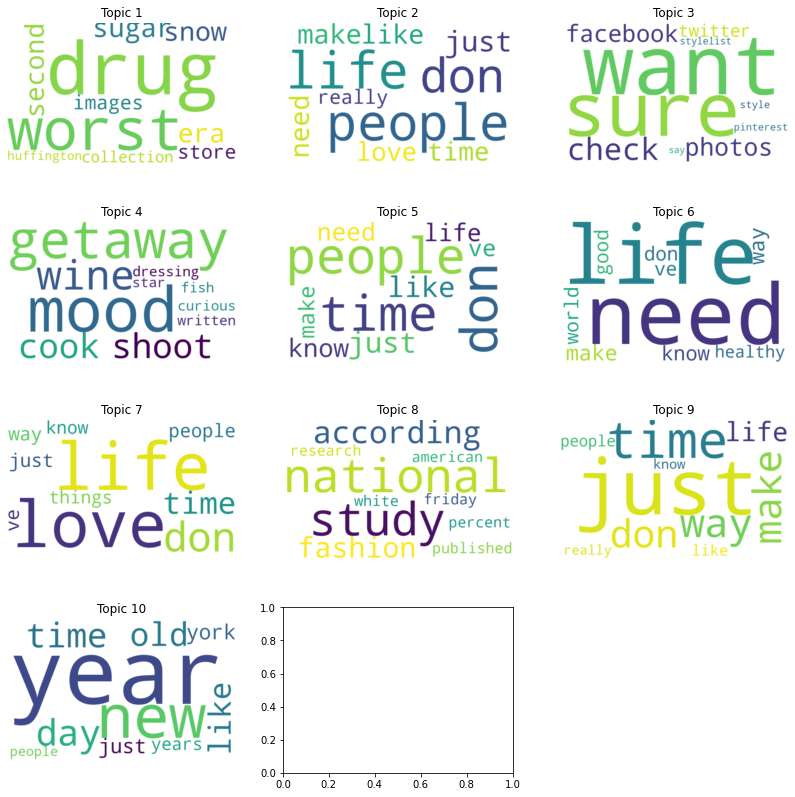

In [48]:
def plot_word_cloud_aevb(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:10].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:10] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")


beta = prodLDA.beta()
fig, axs = plt.subplots(4, 3, figsize=(14, 14))
for n in range(beta.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud_aevb(beta[n], axs[i, j], vocab, n)
axs[-1, -1].axis('off');

plt.show()

In [165]:
lda_sklearn_topics

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topics,,,,,,,,,,
0,people,states,world,year,black,united,women,america,country,national
1,new,check,want,twitter,facebook,huffpost,style,sure,like,york
2,news,video,new,star,study,welcome,host,day,week,morning
3,trump,said,president,donald,state,campaign,says,new,republican,clinton
4,don,children,health,know,kids,people,parents,time,work,new
5,women,love,cancer,marriage,divorce,family,good,men,mother,relationship
6,old,year,just,years,got,did,said,man,white,ago
7,time,day,ve,just,like,year,little,new,make,season
8,make,like,food,great,time,ll,way,culture,good,making


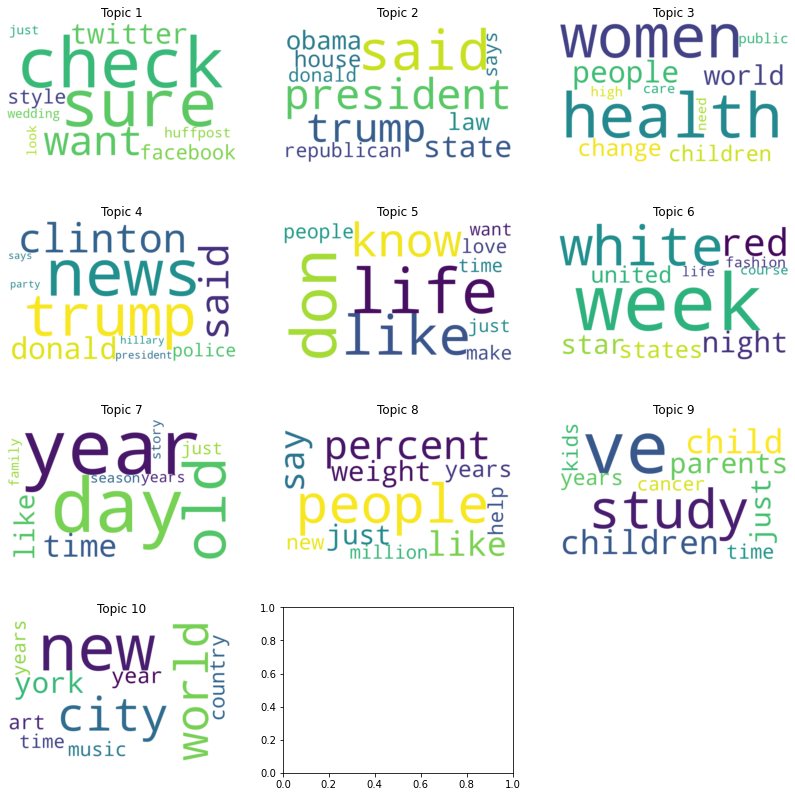

In [46]:
def plot_word_cloud_sklearn(b, ax, n):
#     sorted_, indices = torch.sort(b, descending=True)
#     df = pd.DataFrame(indices[:10].numpy(), columns=['index'])
#     words = pd.merge(df, vocab[['index', 'word']],
#                      how='left', on='index')['word'].values.tolist()
#     sizes = (sorted_[:10] * 1000).int().numpy().tolist()
#     freqs = {words[i]: sizes[i] for i in range(len(words))}
    indices_ = b.argsort()[:-10-1:-1]
    words = [lda_news.Words[i] for i in indices_]
    sorted_ = sorted(b)[:-10-1:-1]
    sizes = (sorted_[:10] * 1000)
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")



fig, axs = plt.subplots(4, 3, figsize=(14, 14))
for n in range(lda_news.lda.components_.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud_sklearn(lda_news.lda.components_[n], axs[i, j], n)
axs[-1, -1].axis('off');

plt.show()

In [166]:
topics_lda_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic,,,,,,,,,,
0,new,year,week,film,star,news,york,night,video,series
0,year,old,said,people,police,years,man,just,killed,week
0,trump,president,said,donald,state,obama,says,house,campaign,republican
0,check,twitter,facebook,style,huffpost,want,sure,pinterest,fashion,look
0,don,just,like,know,time,want,people,think,really,make
0,life,people,time,way,make,world,need,love,work,like
0,health,people,new,women,study,care,percent,world,research,children
0,new,city,world,travel,year,day,country,time,like,york
0,food,day,make,like,time,just,eat,good,eating,ve


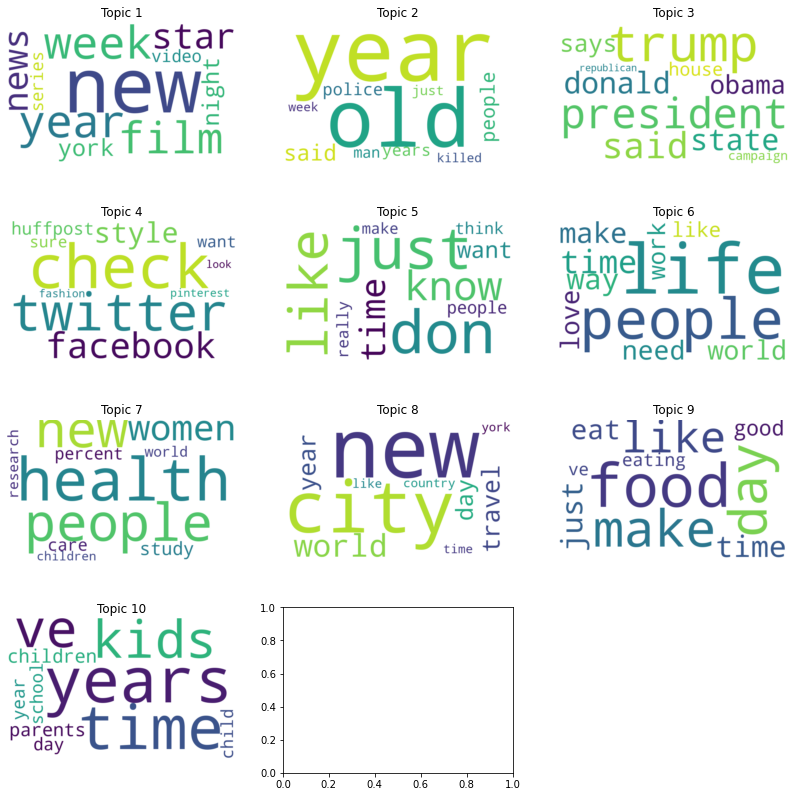

In [49]:
topics_lda = lda.get_topics(10)
def plot_word_cloud_sampling(b1,b2, ax, n):
#     sorted_, indices = torch.sort(b, descending=True)
#     df = pd.DataFrame(indices[:10].numpy(), columns=['index'])
#     words = pd.merge(df, vocab[['index', 'word']],
#                      how='left', on='index')['word'].values.tolist()
#     sizes = (sorted_[:10] * 1000).int().numpy().tolist()
#     freqs = {words[i]: sizes[i] for i in range(len(words))}
    
    words = b1

    sizes = b2
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")



fig, axs = plt.subplots(4, 3, figsize=(14, 14))
for n in range(lda_news.lda.components_.shape[0]):
    i, j = divmod(n, 3)
    plot_word_cloud_sampling(topics_lda[0][n],topics_lda[1][n], axs[i, j], n)
axs[-1, -1].axis('off');

plt.show()

## Quantitative Comparison of Topics Generated

In [140]:
#we compare topics generated using a Jaccard index
#Jaccard = number of words shared between topics/ total number of words in both topics
# source for jaccard definition: https://www.statisticshowto.com/jaccard-index/
def calculate_jaccard(topic1,topic2):
    words_topic1 = topic1 
    words_topic2 = topic2
    
    
    # Find the number of words shared
    intersection = len(words_topic1.intersection(words_topic2))
    # Find the total words
    union = len(words_topic1.union(words_topic2))
    
        
    # Calculate Jaccard similarity score 
    # using length of intersection set divided by length of union set
    return (intersection / union)

#compare autoencoder topics to sklearn topics
jaccard_autoencoder_sklearn = pd.DataFrame()
for i in range(topics_autoencoder.shape[0]):
    topic_autoencoder = set((list(topics_autoencoder.iloc[i,:])))
    for j in range(lda_sklearn_topics.shape[0]):
        topic_sklearn = set((list(lda_sklearn_topics.iloc[j,:])))
        jaccard = calculate_jaccard(topic_autoencoder,topic_sklearn)
        df_temp = pd.DataFrame({'autoencoder_topic':[i],'sklearn_topic':[j],'jaccard':[jaccard]})
        jaccard_autoencoder_sklearn = jaccard_autoencoder_sklearn.append(df_temp)

#compare autoencoder topics to sampling topics
jaccard_autoencoder_sampling = pd.DataFrame()
for i in range(topics_autoencoder.shape[0]):
    topic_autoencoder = set((list(topics_autoencoder.iloc[i,:])))
    for j in range(topics_lda_df.shape[0]):
        topic_sampling = set((list(topics_lda_df.iloc[j,:])))
        jaccard = calculate_jaccard(topic_autoencoder,topic_sampling)
        df_temp = pd.DataFrame({'autoencoder_topic':[i],'sampling_topic':[j],'jaccard':[jaccard]})
        jaccard_autoencoder_sampling = jaccard_autoencoder_sampling.append(df_temp)    

#compare sklearn topics to sampling topics
jaccard_sklearn_sampling = pd.DataFrame()
for i in range(lda_sklearn_topics.shape[0]):
    topic_sklearn = set((list(lda_sklearn_topics.iloc[i,:])))
    for j in range(topics_lda_df.shape[0]):
        topic_sampling = set((list(topics_lda_df.iloc[j,:])))
        jaccard = calculate_jaccard(topic_sklearn,topic_sampling)
        df_temp = pd.DataFrame({'sklearn_topic':[i],'sampling_topic':[j],'jaccard':[jaccard]})
        jaccard_sklearn_sampling = jaccard_sklearn_sampling.append(df_temp)   



In [188]:
jaccard_autoencoder_sklearn['jaccard'].mean()

0.07940586761020196

In [189]:
jaccard_autoencoder_sampling['jaccard'].mean()

0.09877038939732435

In [190]:
jaccard_sklearn_sampling['jaccard'].mean()

0.09593336659900123

In [191]:
v1 = jaccard_autoencoder_sklearn[['autoencoder_topic','jaccard']].groupby('autoencoder_topic').max().mean()
v2 = jaccard_autoencoder_sklearn[['sklearn_topic','jaccard']].groupby('sklearn_topic').max().mean()
np.mean([v1,v2])

0.25973266499582287

In [192]:
v1 = jaccard_autoencoder_sampling[['autoencoder_topic','jaccard']].groupby('autoencoder_topic').max().mean()
v2 = jaccard_autoencoder_sampling[['sampling_topic','jaccard']].groupby('sampling_topic').max().mean()
np.mean([v1,v2])

0.35240802798852333

In [193]:
v1 =jaccard_sklearn_sampling[['sklearn_topic','jaccard']].groupby('sklearn_topic').max().mean()
v2 =jaccard_sklearn_sampling[['sampling_topic','jaccard']].groupby('sampling_topic').max().mean()
np.mean([v1,v2])

0.3923617017657265

In [185]:
max_df = jaccard_autoencoder_sklearn.sort_values(by = 'jaccard',ascending = False).head(1)
aevb_index = max_df['autoencoder_topic'].values[0]
sklearn_index = max_df['sklearn_topic'].values[0]
jaccard_score = max_df['jaccard'].values[0]
display(pd.DataFrame({'Words in ProdLDA topic':list(topics_autoencoder.iloc[aevb_index,:]),'Words in SKLearn Topic':list(lda_sklearn_topics.iloc[sklearn_index,:]),'Jaccard Score':jaccard_score}))

print(jaccard_score)
print('AEVB Topic: ' +str(aevb_index))
print('SKLearn TOpic: '+str(sklearn_index))

,Words in ProdLDA topic,Words in SKLearn Topic,Jaccard Score
0,year,time,0.428571
1,new,day,0.428571
2,day,ve,0.428571
3,time,just,0.428571
4,old,like,0.428571
5,like,year,0.428571
6,york,little,0.428571
7,just,new,0.428571
8,years,make,0.428571
9,people,season,0.428571


0.42857142857142855
AEVB Topic: 9
SKLearn TOpic: 7


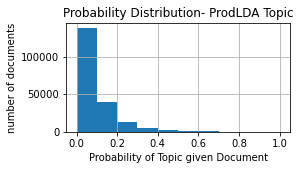

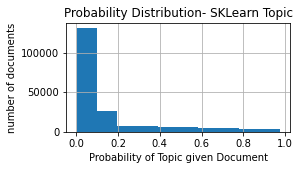

In [155]:
theta_autoencoder['Topic 9'].hist(figsize = (4,2))
plt.ylabel('number of documents')
plt.xlabel('Probability of Topic given Document')
plt.title('Probability Distribution- ProdLDA Topic')
plt.show()
lda_sklearn_predictions['Topic 7'].hist(figsize = (4,2))
plt.ylabel('number of documents')
plt.xlabel('Probability of Topic given Document')
plt.title('Probability Distribution- SKLearn Topic')
plt.show()

In [186]:
max_df = jaccard_autoencoder_sampling.sort_values(by = 'jaccard',ascending = False).head(1)
aevb_index = max_df['autoencoder_topic'].values[0]
sampling_index = max_df['sampling_topic'].values[0]
jaccard_score = max_df['jaccard'].values[0]
display(pd.DataFrame({'Words in ProdLDA topic':list(topics_autoencoder.iloc[aevb_index,:]),'Words in MCMC topic':list(topics_lda_df.iloc[sampling_index,:]),'Jaccard Score':jaccard_score}))

print(jaccard_score)
print('AEVB Topic: ' +str(aevb_index))
print('Sampling Topic: '+str(sampling_index))

,Words in ProdLDA topic,Words in MCMC topic,Jaccard Score
0,just,don,0.666667
1,time,just,0.666667
2,way,like,0.666667
3,make,know,0.666667
4,don,time,0.666667
5,life,want,0.666667
6,people,people,0.666667
7,like,think,0.666667
8,know,really,0.666667
9,really,make,0.666667


0.6666666666666666
AEVB Topic: 8
Sampling Topic: 4


In [ ]:
sampling_predictions = pd.DataFrame(lda.get_theta())

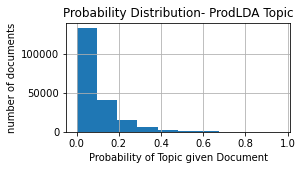

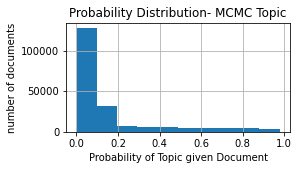

In [157]:
theta_autoencoder['Topic 8'].hist(figsize = (4,2))
plt.ylabel('number of documents')
plt.xlabel('Probability of Topic given Document')
plt.title('Probability Distribution- ProdLDA Topic')
plt.show()



sampling_predictions[4].hist(figsize = (4,2))
plt.ylabel('number of documents')
plt.xlabel('Probability of Topic given Document')
plt.title('Probability Distribution- MCMC Topic')
plt.show()

In [187]:
max_df = jaccard_sklearn_sampling.sort_values(by = 'jaccard',ascending = False).head(1)
sklearn_index = max_df['sklearn_topic'].values[0]
sampling_index = max_df['sampling_topic'].values[0]
jaccard_score = max_df['jaccard'].values[0]
display(pd.DataFrame({'Words in SKLearn topic':list(lda_sklearn_topics.iloc[sklearn_index,:]),'Words in MCMC topic':list(topics_lda_df.iloc[sampling_index,:]),'Jaccard Score':jaccard_score}))

print(jaccard_score)
print('SKLearn Topic: ' +str(sklearn_index))
print('Sampling Topic: '+str(sampling_index))

,Words in SKLearn topic,Words in MCMC topic,Jaccard Score
0,trump,trump,0.666667
1,said,president,0.666667
2,president,said,0.666667
3,donald,donald,0.666667
4,state,state,0.666667
5,campaign,obama,0.666667
6,says,says,0.666667
7,new,house,0.666667
8,republican,campaign,0.666667
9,clinton,republican,0.666667


0.6666666666666666
SKLearn Topic: 3
Sampling Topic: 2


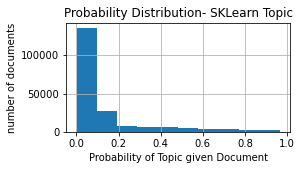

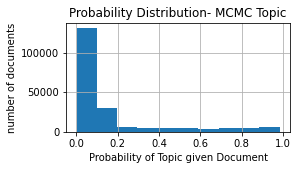

In [161]:
lda_sklearn_predictions['Topic 3'].hist(figsize = (4,2))
plt.ylabel('number of documents')
plt.xlabel('Probability of Topic given Document')
plt.title('Probability Distribution- SKLearn Topic')
plt.show()

sampling_predictions[2].hist(figsize = (4,2))
plt.ylabel('number of documents')
plt.xlabel('Probability of Topic given Document')
plt.title('Probability Distribution- MCMC Topic')
plt.show()

### Sources

Naushan, H. (2021). Topic Modeling with Latent Dirichlet Allocation. Medium. Retrieved 8 November 2021, from https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-e7ff75290f8.

Blei, David & Ng, Andrew & Jordan, Michael. (2001). Latent Dirichlet Allocation. The Journal of Machine Learning Research. 3. 601-608. 

Srivastava, A., & Sutton, C. (2016). Neural Variational Inference For Topic Models.

Misra, R. (2018). News Category Dataset [Data set]. doi:10.13140/RG.2.2.20331.18729.

Spangher, A. (2021). Building the Next New York Times Recommendation Engine. Open Blog. Retrieved 8 November 2021, from https://open.blogs.nytimes.com/2015/08/11/building-the-next-new-york-times-recommendation-engine/.

R, M. (2021). Topic Modeling: Art of Storytelling in NLP. Medium. Retrieved 8 November 2021, from https://medium.com/technovators/topic-modeling-art-of-storytelling-in-nlp-4dc83e96a987.

https://pyro.ai/examples/prodlda.html

https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c ## FC1 definition

https://brilliant.org/wiki/feedforward-neural-networks/ ## Feed Forward Neural Networks 

https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/ ## Batch normalization

https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html#torch.nn.functional.softmax ## Softmax explanation

https://valelab4.ucsf.edu/svn/3rdpartypublic/boost/libs/math/doc/sf_and_dist/html/math_toolkit/dist/dist_ref/dists/lognormal_dist.html ## Parameters "location" ~ mean, "scale" ~ standard deviation for log normal distributions

https://pyro.ai/examples/tensor_shapes.html ## to_event() function explained